In [1]:
DATASET_PATH = "../output_frames.csv"

## Foundation

Include required libraries and tools under this section and adjust settings.

**TODO:**
- [ ] Explore the usage of garbage collections.

In [2]:
# Import required libraries.
import  tensorflow as tf

from    keras.models import Sequential
from    keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from    keras.utils import to_categorical

# Helper libraries.
import  pandas as pd
import  numpy as np
from    sklearn.model_selection import train_test_split
from    sklearn.preprocessing import LabelEncoder
import  librosa

# Libraries for plotting.
import  matplotlib.pyplot as plt

# Other
import sys
import os
import zipfile

2025-03-17 20:53:23.387094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742241203.414190   54156 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742241203.421037   54156 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 20:53:23.445248: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/fridh/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. 

In [3]:
# Test for GPU and determine what GPU we have.
# Modified by student to remove warningen caused on local machine.
IN_COLAB = 'google.colab' in sys.modules

gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    compute_capability=details.get('compute_capability')
    print("Compute capability:",compute_capability)
    if compute_capability[0]>6:
        print("Turn on mixed_float16")
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
else:
    print("No GPU detected.")

Compute capability: (7, 5)
Turn on mixed_float16


In [4]:
# Modify GPU memory allocator to try to prevent full GPU memory.
# This can in some cases be counter productive!
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [5]:
# Install Keras Tuner via PIP (if in colab).
if IN_COLAB:
    os.system('pip install keras_tuner')

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

Keras Tuner version: 1.4.7


## Import Dataset

If you're using Google Colab, the dataset has to be imported from Google Drive (or uploaded as a ZIP-file). This required giving permission to Google Colab! Otherwise, it will check if the dataset folder exists, if not, terminates the execution.

**TODO:**
- [ ] Add support for uploaded dataset.zip files.

In [6]:

if (not os.path.exists(DATASET_PATH)):
    print("Error: Dataset not found.")
    sys.exit()

In [7]:
df = pd.read_csv(DATASET_PATH, header=None)              # No header in your format
dataset = df.iloc[:, :-1].to_numpy(dtype=np.float16)            # All but last column as float16
labels_set = df.iloc[:, -1].to_numpy(dtype=str)                 # Last column as string

In [39]:
dataset = dataset.reshape(dataset.shape[0], 25, 16, 1)
# Transpose each data point.
#dataset = np.array([x.T for x in dataset])
input_shape = dataset[0].shape

print(f"Dataset shape: {dataset.shape}")
print(f"Labels shape: {labels_set.shape}")
print(f"Input shape: {input_shape}")

Dataset shape: (583554, 25, 16, 1)
Labels shape: (583554,)
Input shape: (25, 16, 1)


# Preparing dataset

To prepare the data, we first read through each frame file from the dataset and stores the path alongside it's label in array **dataset** and also addes the label, if not already existing, to **labels**.

We then prepare a function to reads TXT file data and convert it to NP array, followed by a function used for plotting int MFCC for debugging.

In [9]:
# Plot MFCC
def plot_mfcc(mfccs):
    # Flatten the data
    mfccs = mfccs.reshape((25, 16))
    # Plot the MFCC
    print(f"MFCC shape: {mfccs.shape}")
    mfccs = mfccs
    librosa.display.specshow(mfccs, x_axis='time', sr=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficient')
    plt.show()

MFCC shape: (25, 16)


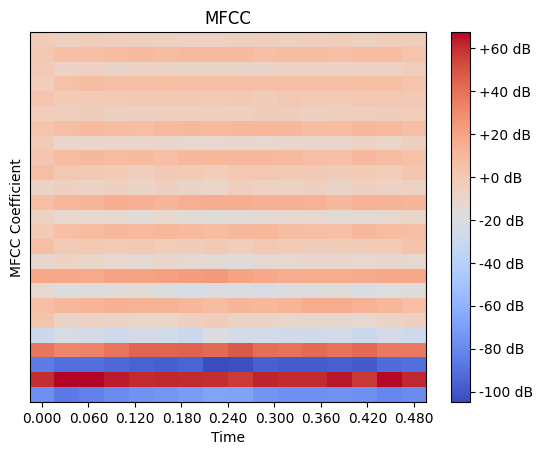

In [10]:
# Pass exmaple frame data to plot_mfcc function.
plot_mfcc(dataset[0])

### Splitting Dataset

When data have been explored, we split the data into three groups: training, validating, and testing. Where training and validating will be used for the training process, and testing for the final testing.

In [40]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dataset, labels_set, test_size=0.2, random_state=42, stratify=labels_set)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Print the lengths of the training, validation, and testing sets.
print(f"Training set length: {len(x_train)}")
print(f"Validation set length: {len(x_val)}")
print(f"Testing set length: {len(x_test)}")

Training set length: 373474
Validation set length: 93369
Testing set length: 116711


In [41]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights.
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
dist_class_weight = dict(enumerate(class_weight))

In [13]:
print(f"Classes: {np.unique(labels_set)}")

Classes: ['Background_noise' 'Bus' 'Car' 'Motorcycle' 'Truck']


In [42]:
# Hot end code the labels.
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.fit_transform(y_test))
y_val = to_categorical(label_encoder.fit_transform(y_val))

# Helper Functions

There are two helper functions: printHistory (used for plotting graphs to udnerstand over- and udner-fitting), as well as fitModel (used for fitting model one or multiple times).

In [15]:
# Print training history
# Function used for printing two plots, one for accuracy and one for loss.
# To be used with the history object from the fit method
def printHistory(history):
  # Collect the number of epochs run based on the amount of loss value under history.
  epochs = len(history.history['loss'])

  epochrange = range(1, epochs + 1)
  train_acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(epochrange, train_acc, 'bo', label='Training acc')
  plt.plot(epochrange, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochrange, train_loss, 'bo', label='Training loss')
  plt.plot(epochrange, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [16]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

# Fit model function used for convinience when fitting the model multiple times
def fitModel(model, x_train, y_train, x_val, y_val, epochs, doPrintHistory, class_weight, verbose, batch_size):

    # Define early stopping callback.
    reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        verbose=verbose,
        class_weight=class_weight,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr_on_plateau],
    )
    # Print history
    if doPrintHistory: printHistory(history)

In [17]:
print(input_shape)

(25, 16)


In [18]:
print((input_shape[0], 1))

(25, 1)


# Construct Sequantial Model

...

In [98]:
from keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv1D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, InputLayer
from tensorflow.keras.regularizers import l2

sequential_model = Sequential([

    InputLayer(shape=input_shape),  # 25 frames, 16 channels

    tf.keras.layers.Reshape((input_shape[0], input_shape[1], 1)),
    Conv2D(filters=128, kernel_size=(5, 1), activation="relu", kernel_regularizer=l2(0.001)),
    Conv2D(filters=256, kernel_size=(5, 1), activation="relu", kernel_regularizer=l2(0.001)),
    Conv2D(filters=512, kernel_size=(5, 1), activation="relu", kernel_regularizer=l2(0.001)),
    tf.keras.layers.Reshape((input_shape[0], -1)),

    # Feature Pooling (Combining Max & Average Pooling)
    Flatten(),

    # Fully Connected Layer
    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),

    # Output Layer (Softmax for multi-class classification)
    Dense(units=len(np.unique(labels_set)), activation="softmax")
])


ValueError: The total size of the tensor must be unchanged, however, the input size cannot by divided by the specified dimensions in target_shape. Received: input_shape=(13, 16, 512), target_shape=(25, -1)

In [51]:
def compileModel(model, learning_rate = 0.001):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['categorical_accuracy']
    )
    model.summary()

In [94]:
compileModel(sequential_model, 0.001)

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_16 (Reshape)            │ (None, 25, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 25, 16, 128)    │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 25, 16, 256)    │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 25, 16, 512)    │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_17 (Reshape)            │ (None, 25, 8192)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 204800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │    13,107,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,928,325 (53.13 MB)

 Trainable params: 13,928,325 (53.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8


2025-03-17 21:19:01.028768: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=3,k4=2,k5=3,k6=3,k7=2} for conv (f16[64,25,16,256]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,25,16,512]{3,2,1,0}, f16[512,5,1,256]{3,2,1,0}), window={size=5x1 pad=2_2x0_0}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-17 21:19:01.033825: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=3,k6=3,k7=2} for conv (f16[64,25,16,256]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,25,16,512]{3,2,1,0}, f16[512,5,1,256]{3,2,1,0}), window={size=5x1 pad=2_2x0_0}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$con

5830/5836 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - categorical_accuracy: 0.3503 - loss: 1.5111

2025-03-17 21:19:49.876828: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=3,k4=2,k5=3,k6=3,k7=2} for conv (f16[34,25,16,256]{3,2,1,0}, u8[0]{0}) custom-call(f16[34,25,16,512]{3,2,1,0}, f16[512,5,1,256]{3,2,1,0}), window={size=5x1 pad=2_2x0_0}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-17 21:19:49.879774: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=3,k6=3,k7=2} for conv (f16[34,25,16,256]{3,2,1,0}, u8[0]{0}) custom-call(f16[34,25,16,512]{3,2,1,0}, f16[512,5,1,256]{3,2,1,0}), window={size=5x1 pad=2_2x0_0}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$con

5836/5836 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - categorical_accuracy: 0.3503 - loss: 1.5111 - val_categorical_accuracy: 0.4091 - val_loss: 1.4871 - learning_rate: 0.0010
Epoch 2/8
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - categorical_accuracy: 0.4063 - loss: 1.4358 - val_categorical_accuracy: 0.4121 - val_loss: 1.4828 - learning_rate: 0.0010
Epoch 3/8
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - categorical_accuracy: 0.4137 - loss: 1.4287 - val_categorical_accuracy: 0.4121 - val_loss: 1.4821 - learning_rate: 0.0010
Epoch 4/8
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - categorical_accuracy: 0.4165 - loss: 1.4250 - val_categorical_accuracy: 0.4177 - val_loss: 1.4761 - learning_rate: 0.0010
Epoch 5/8
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step - categorical_accuracy: 0.4186 - loss: 1.4224 - val_categorical_accuracy: 0.4149 - val_loss: 1.4790 - learning_rate: 0.0010
Epoch 6/8
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - categorical_accuracy: 0.4208 - loss: 1.4204 - val_categorical_a

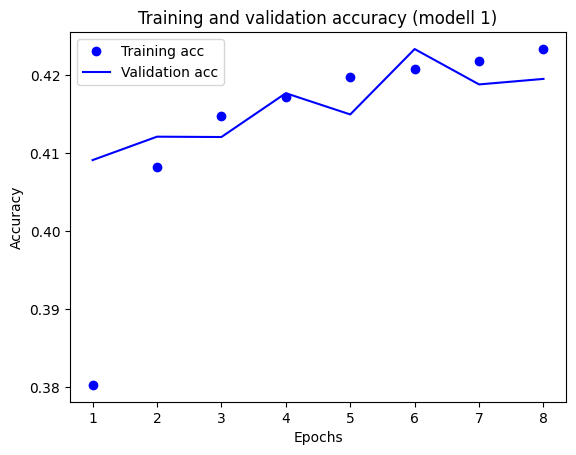

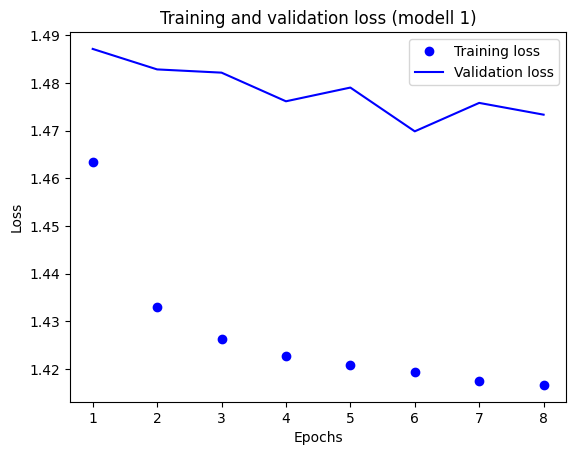

In [75]:
fitModel(sequential_model, x_train, y_train, x_val, y_val, 8, True, dist_class_weight, 1, 64)

In [76]:
# Test the model.
test_loss, test_accuracy = sequential_model.evaluate(x_test, y_test, verbose=1)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

3648/3648 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - categorical_accuracy: 0.4272 - loss: 1.4691
Test loss: 1.468902349472046
Test accuracy: 0.42684921622276306


In [95]:
# Export the model in HDF5 format
sequential_model.save('sequential_model.h5')
sequential_model.save('sequential_model.keras')

In [97]:
from keras.models import load_model

# Load the model
loaded_model = load_model('sequential_model.keras')

# Evaluate the loaded model
loaded_test_loss, loaded_test_accuracy = loaded_model.evaluate(x_test, y_test, verbose=1)
print(f"Loaded model test loss: {loaded_test_loss}")
print(f"Loaded model test accuracy: {loaded_test_accuracy}")

/home/fridh/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 16 variables whereas the saved optimizer has 4 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/fridh/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3648/3648 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - categorical_accuracy: 0.1750 - loss: 2.2625
Loaded model test loss: 2.261930227279663
Loaded model test accuracy: 0.17622160911560059


In [96]:
import tensorflow as tf

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model has been converted to TensorFlow Lite and saved as 'model.tflite'")

INFO:tensorflow:Assets written to: /tmp/tmpo85u_oaw/assets


INFO:tensorflow:Assets written to: /tmp/tmpo85u_oaw/assets


Saved artifact at '/tmp/tmpo85u_oaw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 25, 16, 1), dtype=tf.float32, name='input_layer_23')
Output Type:
  TensorSpec(shape=(None, 25, 8192), dtype=tf.float16, name=None)
Captures:
  131999834845456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131999834848800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131999834856912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131999834856384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131999834861840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131999834861312: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1742243461.278952   54156 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1742243461.278968   54156 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-17 21:31:01.279185: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpo85u_oaw
2025-03-17 21:31:01.279729: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-17 21:31:01.279744: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpo85u_oaw
2025-03-17 21:31:01.284074: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-17 21:31:01.317331: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpo85u_oaw
2025-03-17 21:31:01.326071: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 46889 microseconds.
loc(callsite(callsite(fused["Conv2D:", "seque

ConverterError: Could not translate MLIR to FlatBuffer.<unknown>:0: error: loc(callsite(callsite(fused["Conv2D:", "sequential_22_1/conv2d_67_1/convolution@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.Conv2D' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["Conv2D:", "sequential_22_1/conv2d_67_1/convolution@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %11 = "tf.Conv2D"(%10, %5) <{data_format = "NHWC", dilations = [1, 1, 1, 1], explicit_paddings = [], padding = "SAME", strides = [1, 1, 1, 1], use_cudnn_on_gpu = true}> {device = ""} : (tensor<?x25x16x1xf16>, tensor<5x1x1x128xf16>) -> tensor<?x25x16x128xf16>
<unknown>:0: note: loc(callsite(callsite(fused["Conv2D:", "sequential_22_1/conv2d_67_1/convolution@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["BiasAdd:", "sequential_22_1/conv2d_67_1/BiasAdd@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.BiasAdd' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["BiasAdd:", "sequential_22_1/conv2d_67_1/BiasAdd@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %12 = "tf.BiasAdd"(%11, %4) <{data_format = "NHWC"}> {device = ""} : (tensor<?x25x16x128xf16>, tensor<128xf16>) -> tensor<?x25x16x128xf16>
<unknown>:0: note: loc(callsite(callsite(fused["BiasAdd:", "sequential_22_1/conv2d_67_1/BiasAdd@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["Relu:", "sequential_22_1/conv2d_67_1/Relu@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.Relu' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["Relu:", "sequential_22_1/conv2d_67_1/Relu@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %13 = "tf.Relu"(%12) {device = ""} : (tensor<?x25x16x128xf16>) -> tensor<?x25x16x128xf16>
<unknown>:0: note: loc(callsite(callsite(fused["Relu:", "sequential_22_1/conv2d_67_1/Relu@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["Conv2D:", "sequential_22_1/conv2d_68_1/convolution@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.Conv2D' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["Conv2D:", "sequential_22_1/conv2d_68_1/convolution@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %14 = "tf.Conv2D"(%13, %3) <{data_format = "NHWC", dilations = [1, 1, 1, 1], explicit_paddings = [], padding = "SAME", strides = [1, 1, 1, 1], use_cudnn_on_gpu = true}> {device = ""} : (tensor<?x25x16x128xf16>, tensor<5x1x128x256xf16>) -> tensor<?x25x16x256xf16>
<unknown>:0: note: loc(callsite(callsite(fused["Conv2D:", "sequential_22_1/conv2d_68_1/convolution@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["BiasAdd:", "sequential_22_1/conv2d_68_1/BiasAdd@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.BiasAdd' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["BiasAdd:", "sequential_22_1/conv2d_68_1/BiasAdd@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %15 = "tf.BiasAdd"(%14, %2) <{data_format = "NHWC"}> {device = ""} : (tensor<?x25x16x256xf16>, tensor<256xf16>) -> tensor<?x25x16x256xf16>
<unknown>:0: note: loc(callsite(callsite(fused["BiasAdd:", "sequential_22_1/conv2d_68_1/BiasAdd@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["Relu:", "sequential_22_1/conv2d_68_1/Relu@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.Relu' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["Relu:", "sequential_22_1/conv2d_68_1/Relu@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %16 = "tf.Relu"(%15) {device = ""} : (tensor<?x25x16x256xf16>) -> tensor<?x25x16x256xf16>
<unknown>:0: note: loc(callsite(callsite(fused["Relu:", "sequential_22_1/conv2d_68_1/Relu@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["Conv2D:", "sequential_22_1/conv2d_69_1/convolution@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.Conv2D' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["Conv2D:", "sequential_22_1/conv2d_69_1/convolution@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %17 = "tf.Conv2D"(%16, %1) <{data_format = "NHWC", dilations = [1, 1, 1, 1], explicit_paddings = [], padding = "SAME", strides = [1, 1, 1, 1], use_cudnn_on_gpu = true}> {device = ""} : (tensor<?x25x16x256xf16>, tensor<5x1x256x512xf16>) -> tensor<?x25x16x512xf16>
<unknown>:0: note: loc(callsite(callsite(fused["Conv2D:", "sequential_22_1/conv2d_69_1/convolution@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["BiasAdd:", "sequential_22_1/conv2d_69_1/BiasAdd@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.BiasAdd' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["BiasAdd:", "sequential_22_1/conv2d_69_1/BiasAdd@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %18 = "tf.BiasAdd"(%17, %0) <{data_format = "NHWC"}> {device = ""} : (tensor<?x25x16x512xf16>, tensor<512xf16>) -> tensor<?x25x16x512xf16>
<unknown>:0: note: loc(callsite(callsite(fused["BiasAdd:", "sequential_22_1/conv2d_69_1/BiasAdd@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["Relu:", "sequential_22_1/conv2d_69_1/Relu@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.Relu' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["Relu:", "sequential_22_1/conv2d_69_1/Relu@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %19 = "tf.Relu"(%18) {device = ""} : (tensor<?x25x16x512xf16>) -> tensor<?x25x16x512xf16>
<unknown>:0: note: loc(callsite(callsite(fused["Relu:", "sequential_22_1/conv2d_69_1/Relu@__inference_function_508161"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_508196"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops are not supported by the native TFLite runtime, you can enable TF kernels fallback using TF Select. See instructions: https://www.tensorflow.org/lite/guide/ops_select 
TF Select ops: BiasAdd, Conv2D, Relu
Details:
	tf.BiasAdd(tensor<?x25x16x128xf16>, tensor<128xf16>) -> (tensor<?x25x16x128xf16>) : {data_format = "NHWC", device = ""}
	tf.BiasAdd(tensor<?x25x16x256xf16>, tensor<256xf16>) -> (tensor<?x25x16x256xf16>) : {data_format = "NHWC", device = ""}
	tf.BiasAdd(tensor<?x25x16x512xf16>, tensor<512xf16>) -> (tensor<?x25x16x512xf16>) : {data_format = "NHWC", device = ""}
	tf.Conv2D(tensor<?x25x16x128xf16>, tensor<5x1x128x256xf16>) -> (tensor<?x25x16x256xf16>) : {data_format = "NHWC", device = "", dilations = [1, 1, 1, 1], explicit_paddings = [], padding = "SAME", strides = [1, 1, 1, 1], use_cudnn_on_gpu = true}
	tf.Conv2D(tensor<?x25x16x1xf16>, tensor<5x1x1x128xf16>) -> (tensor<?x25x16x128xf16>) : {data_format = "NHWC", device = "", dilations = [1, 1, 1, 1], explicit_paddings = [], padding = "SAME", strides = [1, 1, 1, 1], use_cudnn_on_gpu = true}
	tf.Conv2D(tensor<?x25x16x256xf16>, tensor<5x1x256x512xf16>) -> (tensor<?x25x16x512xf16>) : {data_format = "NHWC", device = "", dilations = [1, 1, 1, 1], explicit_paddings = [], padding = "SAME", strides = [1, 1, 1, 1], use_cudnn_on_gpu = true}
	tf.Relu(tensor<?x25x16x128xf16>) -> (tensor<?x25x16x128xf16>) : {device = ""}
	tf.Relu(tensor<?x25x16x256xf16>) -> (tensor<?x25x16x256xf16>) : {device = ""}
	tf.Relu(tensor<?x25x16x512xf16>) -> (tensor<?x25x16x512xf16>) : {device = ""}

<unknown>:0: note: see current operation: 
"func.func"() <{arg_attrs = [{tf_saved_model.index_path = ["input_layer_23"]}], function_type = (tensor<?x25x16x1xf32>) -> tensor<?x25x8192xf16>, res_attrs = [{tf_saved_model.index_path = ["output_0"]}], sym_name = "main"}> ({
^bb0(%arg0: tensor<?x25x16x1xf32>):
  %0 = "arith.constant"() <{value = dense<0.000000e+00> : tensor<512xf16>}> : () -> tensor<512xf16>
  %1 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<5x1x256x512xf16>}> : () -> tensor<5x1x256x512xf16>
  %2 = "arith.constant"() <{value = dense<0.000000e+00> : tensor<256xf16>}> : () -> tensor<256xf16>
  %3 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<5x1x128x256xf16>}> : () -> tensor<5x1x128x256xf16>
  %4 = "arith.constant"() <{value = dense<0.000000e+00> : tensor<128xf16>}> : () -> tensor<128xf16>
  %5 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<5x1x1x128xf16>}> : () -> tensor<5x1x1x128xf16>
  %6 = "arith.constant"() <{value = dense<8192> : tensor<i32>}> : () -> tensor<i32>
  %7 = "arith.constant"() <{value = dense<1> : tensor<1xi32>}> : () -> tensor<1xi32>
  %8 = "arith.constant"() <{value = dense<0> : tensor<1xi32>}> : () -> tensor<1xi32>
  %9 = "arith.constant"() <{value = dense<25> : tensor<i32>}> : () -> tensor<i32>
  %10 = "tfl.cast"(%arg0) : (tensor<?x25x16x1xf32>) -> tensor<?x25x16x1xf16>
  %11 = "tf.Conv2D"(%10, %5) <{data_format = "NHWC", dilations = [1, 1, 1, 1], explicit_paddings = [], padding = "SAME", strides = [1, 1, 1, 1], use_cudnn_on_gpu = true}> {device = ""} : (tensor<?x25x16x1xf16>, tensor<5x1x1x128xf16>) -> tensor<?x25x16x128xf16>
  %12 = "tf.BiasAdd"(%11, %4) <{data_format = "NHWC"}> {device = ""} : (tensor<?x25x16x128xf16>, tensor<128xf16>) -> tensor<?x25x16x128xf16>
  %13 = "tf.Relu"(%12) {device = ""} : (tensor<?x25x16x128xf16>) -> tensor<?x25x16x128xf16>
  %14 = "tf.Conv2D"(%13, %3) <{data_format = "NHWC", dilations = [1, 1, 1, 1], explicit_paddings = [], padding = "SAME", strides = [1, 1, 1, 1], use_cudnn_on_gpu = true}> {device = ""} : (tensor<?x25x16x128xf16>, tensor<5x1x128x256xf16>) -> tensor<?x25x16x256xf16>
  %15 = "tf.BiasAdd"(%14, %2) <{data_format = "NHWC"}> {device = ""} : (tensor<?x25x16x256xf16>, tensor<256xf16>) -> tensor<?x25x16x256xf16>
  %16 = "tf.Relu"(%15) {device = ""} : (tensor<?x25x16x256xf16>) -> tensor<?x25x16x256xf16>
  %17 = "tf.Conv2D"(%16, %1) <{data_format = "NHWC", dilations = [1, 1, 1, 1], explicit_paddings = [], padding = "SAME", strides = [1, 1, 1, 1], use_cudnn_on_gpu = true}> {device = ""} : (tensor<?x25x16x256xf16>, tensor<5x1x256x512xf16>) -> tensor<?x25x16x512xf16>
  %18 = "tf.BiasAdd"(%17, %0) <{data_format = "NHWC"}> {device = ""} : (tensor<?x25x16x512xf16>, tensor<512xf16>) -> tensor<?x25x16x512xf16>
  %19 = "tf.Relu"(%18) {device = ""} : (tensor<?x25x16x512xf16>) -> tensor<?x25x16x512xf16>
  %20 = "tfl.shape"(%19) : (tensor<?x25x16x512xf16>) -> tensor<4xi32>
  %21 = "tfl.strided_slice"(%20, %8, %7, %7) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<4xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %22 = "tfl.pack"(%21, %9, %6) <{axis = 0 : i32, values_count = 3 : i32}> : (tensor<i32>, tensor<i32>, tensor<i32>) -> tensor<3xi32>
  %23 = "tfl.reshape"(%19, %22) : (tensor<?x25x16x512xf16>, tensor<3xi32>) -> tensor<?x25x8192xf16>
  "func.return"(%23) : (tensor<?x25x8192xf16>) -> ()
}) {tf.entry_function = {control_outputs = "", inputs = "serving_default_input_layer_23:0", outputs = "StatefulPartitionedCall_1:0"}, tf_saved_model.exported_names = ["serving_default"]} : () -> ()
